# Causal reasoning for Buchwald-Hartwig reaction classficaition task

## 1. Memory Structure approach 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np


## 1.2 SMILES & extra features dataset - Causal stimulation on few-shot examples

### 1.2.1 Prompt preparation

In [7]:
df_az = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/Yield_experiment/az_no_rdkit.csv')

In [8]:
def split_smiles_reaction(smiles):
    if isinstance(smiles, str):  
        try:
            # Split the string by '.' to get reactants
            reactants_split = smiles.split('.')
            # Fill with None if fewer than expected
            while len(reactants_split) < 5:
                reactants_split.append(None)
            return pd.Series(reactants_split[:5])  
        except Exception as e:
            return pd.Series([None, None, None, None, None])  
    else:
        return pd.Series([None, None, None, None, None])


In [9]:
def load_and_filter_excel(file_path):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
        return None
    
    required_columns = [
    'Unnamed: 0', 'yield', 'reactant_smiles', 'solvent_smiles',
    'base_smiles', 'product_smiles', 'id', 'temperature', 'metal_amount',
    'amine_amount', 'halide_amount', 'base_amount', 'ligand_amount',
    'reaction_volume', 'solvent_1', 'solvent_2', 'amine_molecular_weight',
    'amine_molecular_volume', 'amine_surface_area', 'amine_ovality',
    'amine_hardness', 'amine_dipole_moment', 'amine_electronegativity',
    'amine_E_HOMO', 'amine_E_LOMO', 'amine_.N1_electrostatic_charge',
    'amine_.N1_NMR_shift', 'amine_.C1_electrostatic_charge',
    'amine_.C1_NMR_shift', 'halide_molecular_weight',
    'halide_molecular_volume', 'halide_surface_area', 'halide_ovality',
    'halide_hardness', 'halide_dipole_moment', 'halide_electronegativity',
    'halide_E_HOMO', 'halide_E_LOMO', 'halide_V0_frequency',
    'halide_V0_intensity', 'halide_V1_frequency', 'halide_V1_intensity',
    'halide_V2_frequency', 'halide_V2_intensity',
    'halide_.C1_electrostatic_charge', 'halide_.C1_NMR_shift',
    'halide_.C2_electrostatic_charge', 'halide_.C2_NMR_shift',
    'ligand_molecular_weight', 'ligand_hardness', 'ligand_dipole_moment',
    'ligand_electronegativity', 'ligand_E_HOMO', 'ligand_E_LOMO',
    'ligand_.P1_electrostatic_charge', 'ligand_.P1_NMR_shift'
    ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None

    
    filtered_df = df[available_columns]

    filtered_df.fillna('unknown', inplace=True)

    filtered_df[['reactant_1', 'reactant_2', 'ligand_1', 'ligand_2', 'Metal catalyst']] = df['reactant_smiles'].apply(split_smiles_reaction)

    return filtered_df


In [10]:
df_az_split = load_and_filter_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/Yield_experiment/az_no_rdkit.csv')

In [11]:
df_az_split.columns

Index(['Unnamed: 0', 'yield', 'reactant_smiles', 'solvent_smiles',
       'base_smiles', 'product_smiles', 'id', 'temperature', 'metal_amount',
       'amine_amount', 'halide_amount', 'base_amount', 'ligand_amount',
       'reaction_volume', 'solvent_1', 'solvent_2', 'amine_molecular_weight',
       'amine_molecular_volume', 'amine_surface_area', 'amine_ovality',
       'amine_hardness', 'amine_dipole_moment', 'amine_electronegativity',
       'amine_E_HOMO', 'amine_E_LOMO', 'amine_.N1_electrostatic_charge',
       'amine_.N1_NMR_shift', 'amine_.C1_electrostatic_charge',
       'amine_.C1_NMR_shift', 'halide_molecular_weight',
       'halide_molecular_volume', 'halide_surface_area', 'halide_ovality',
       'halide_hardness', 'halide_dipole_moment', 'halide_electronegativity',
       'halide_E_HOMO', 'halide_E_LOMO', 'halide_V0_frequency',
       'halide_V0_intensity', 'halide_V1_frequency', 'halide_V1_intensity',
       'halide_V2_frequency', 'halide_V2_intensity',
       'halide_.C1_

In [12]:
df_az_split

,Unnamed: 0,yield,reactant_smiles,solvent_smiles,base_smiles,product_smiles,id,temperature,metal_amount,amine_amount,...,ligand_electronegativity,ligand_E_HOMO,ligand_E_LOMO,ligand_.P1_electrostatic_charge,ligand_.P1_NMR_shift,reactant_1,reactant_2,ligand_1,ligand_2,Metal catalyst
0,0,65.39,CC(C)N1CCNCC1.CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C(...,C1COCCO1,C(=O)([O-])[O-].[Cs+].[Cs+],CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C(C=C(C=C3)F)F)C...,0,110.0,0.00004,0.00177,...,0.11505,-0.18606,-0.04403,0.36563,220.8744,CC(C)N1CCNCC1,CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C(C=C(C=C3)F)F)C...,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,None,None
1,1,57.47,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC.C1=CC=C(C=C1)I...,COC1=CC=CC=C1,C(=O)([O-])[O-].[Cs+].[Cs+],CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,1,100.0,0.00030,0.00762,...,0.10129,-0.18009,-0.02249,0.43995,226.1751,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,C1=CC=C(C=C1)I,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,None,None
2,2,65.43,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC.C1=CC=C(C=C1)I...,COC1=CC=CC=C1,C(=O)([O-])[O-].[Cs+].[Cs+],CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,3,100.0,0.00027,0.00672,...,0.10129,-0.18009,-0.02249,0.43995,226.1751,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,C1=CC=C(C=C1)I,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,None,None
3,3,75.07,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC.C1=CC=C(C=C1)I...,COC1=CC=CC=C1,C(=O)([O-])[O-].[Cs+].[Cs+],CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,4,100.0,0.00027,0.00672,...,0.10129,-0.18009,-0.02249,0.43995,226.1751,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,C1=CC=C(C=C1)I,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,None,None
4,4,46.32,C1=CC(=CC=C1N)S(=O)(=O)N.CC1=NC(=C(C=C1)OC2=CC...,CC(=O)N(C)C,C(=O)([O-])[O-].[Cs+].[Cs+],CC1=NC(=C(C=C1)OC2=CC(=NC=C2)NC3=CC=C(C=C3)S(=...,7,150.0,0.00193,0.03580,...,0.10129,-0.18009,-0.02249,0.43995,226.1751,C1=CC(=CC=C1N)S(=O)(=O)N,CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,745,42.82,C1CNCCN1.C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=...,CC1=CC=CC=C1,CC(C)(C)[O-].[Na+],C1CN(CCN1)C2=CC=CC3=C2N=CN3C(C4=CC=CC=C4)(C5=C...,979,90.0,0.00001,0.00410,...,0.11505,-0.18606,-0.04403,0.36563,220.8744,C1CNCCN1,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)N4C=NC...,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,None,None
746,746,42.75,CC(C)(C)OC(=O)N1CCNCC1.C1=CC(=C(C=C1C(F)(F)F)B...,CC1=CC=CC=C1,CC(C)(C)[O-].[Na+],CC(C)(C)OC(=O)N1CCN(CC1)C2=C(C=CC(=C2)C(F)(F)F)F,982,105.0,0.00021,0.00418,...,0.11505,-0.18606,-0.04403,0.36563,220.8744,CC(C)(C)OC(=O)N1CCNCC1,C1=CC(=C(C=C1C(F)(F)F)Br)F,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,None,None
747,747,46.13,CC(C)(C)OC(=O)N1CCNCC1.C1=CN=C(C=C1C(F)(F)F)Cl...,CC1=CC=CC=C1,CC(C)(C)[O-].[Na+],CC(C)(C)OC(=O)N1CCN(CC1)C2=NC=CC(=C2)C(F)(F)F,983,105.0,0.00071,0.01420,...,0.11505,-0.18606,-0.04403,0.36563,220.8744,CC(C)(C)OC(=O)N1CCNCC1,C1=CN=C(C=C1C(F)(F)F)Cl,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,None,None
748,748,24.34,CC(C)(C)OC(=O)N1CCNCC1.C1=CC2=C(C=CC(=C2N=C1)O...,C1CCOC1,C(=O)([O-])[O-].[Cs+].[Cs+],CC(C)(C)OC(=O)N1CCN(CC1)C2=C3C(=C(C=C2)Cl)C=CC=N3,986,75.0,0.00029,0.00693,...,0.11505,-0.18606,-0.04403,0.36563,220.8744,CC(C)(C)OC(=O)N1CCNCC1,C1=CC2=C(C=CC(=C2N=C1)OS(=O)(=O)C(F)(F)F)Cl,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,None,None


In [13]:
prompts = [
    f"What would be the yield of the reaction involving "
    f"Reactant smiles 1: {row['reactant_1']}\n"
    f"Reactant smiles 2: {row['reactant_2']}\n"
    f"Solvent smiles: {row['solvent_smiles']}\n"
    f"The Base smiles: {row['base_smiles']}\n"
    f"The Metal catalyst smiles: {row['Metal catalyst']}\n"
    f"The ligand smiles: {row[['ligand_1', 'ligand_2']]}\n"

    f"To give the following product smiles: {row['product_smiles']}\n"

    f"Knowing that: \n"
    f"The Temperature of the reaction: {row['temperature']}\n"
    f"Metal catalyst amount is: {row['metal_amount']}\n"
    f"Amine (reactant 1) amount: {row['amine_amount']}\n"
    f"Halide (reactant 2) amount: {row['halide_amount']}\n"
    f"Base amount: {row['base_amount']}\n"
    f"Ligand amount: {row['ligand_amount']}\n"
    f"Reaction volume: {row['reaction_volume']}\n"
    f"Solvent 1: {row['solvent_1']}\n"
    f"Solvent 2: {row['solvent_2']}\n"
    f"Amine (reactant 1) molecular weight: {row['amine_molecular_weight']}\n"
    f"Amine (reactant 1) molecular volume: {row['amine_molecular_volume']}\n"
    f"Amine (reactant 1) surface area: {row['amine_surface_area']}\n"
    f"Amine (reactant 1) ovality: {row['amine_ovality']}\n"
    f"Amine (reactant 1) hardness: {row['amine_hardness']}\n"
    f"Amine (reactant 1) dipole moment: {row['amine_dipole_moment']}\n"
    f"Amine (reactant 1) electronegativity: {row['amine_electronegativity']}\n"
    f"Amine (reactant 1) E HOMO: {row['amine_E_HOMO']}\n"
    f"Amine (reactant 1) E LUMO: {row['amine_E_LOMO']}\n"
    f"Amine (reactant 1) N1 electrostatic charge: {row['amine_.N1_electrostatic_charge']}\n"
    f"Amine (reactant 1) N1 NMR shift: {row['amine_.N1_NMR_shift']}\n"
    f"Amine (reactant 1) C1 electrostatic charge: {row['amine_.C1_electrostatic_charge']}\n"
    f"Amine (reactant 1) C1 NMR shift: {row['amine_.C1_NMR_shift']}\n"
    f"Halide (reactant 2) molecular weight: {row['halide_molecular_weight']}\n"
    f"Halide (reactant 2) molecular volume: {row['halide_molecular_volume']}\n"
    f"Halide (reactant 2) surface area: {row['halide_surface_area']}\n"
    f"Halide (reactant 2) ovality: {row['halide_ovality']}\n"
    f"Halide (reactant 2) hardness: {row['halide_hardness']}\n"
    f"Halide (reactant 2) dipole moment: {row['halide_dipole_moment']}\n"
    f"Halide (reactant 2) electronegativity: {row['halide_electronegativity']}\n"
    f"Halide (reactant 2) E HOMO: {row['halide_E_HOMO']}\n"
    f"Halide (reactant 2) E LUMO: {row['halide_E_LOMO']}\n"
    f"Halide (reactant 2) V0 frequency: {row['halide_V0_frequency']}\n"
    f"Halide (reactant 2) V0 intensity: {row['halide_V0_intensity']}\n"
    f"Halide (reactant 2) V1 frequency: {row['halide_V1_frequency']}\n"
    f"Halide (reactant 2) V1 intensity: {row['halide_V1_intensity']}\n"
    f"Halide (reactant 2) V2 frequency: {row['halide_V2_frequency']}\n"
    f"Halide (reactant 2) V2 intensity: {row['halide_V2_intensity']}\n"
    f"Halide (reactant 2) C1 electrostatic charge: {row['halide_.C1_electrostatic_charge']}\n"
    f"Halide (reactant 2) C1 NMR shift: {row['halide_.C1_NMR_shift']}\n"
    f"Halide (reactant 2) C2 electrostatic charge: {row['halide_.C2_electrostatic_charge']}\n"
    f"Halide (reactant 2) C2 NMR shift: {row['halide_.C2_NMR_shift']}\n"
    f"Ligand (ligand 1 and 2) molecular weight: {row['ligand_molecular_weight']}\n"
    f"Ligand (ligand 1 and 2) hardness: {row['ligand_hardness']}\n"
    f"Ligand (ligand 1 and 2)dipole moment: {row['ligand_dipole_moment']}\n"
    f"Ligand (ligand 1 and 2) electronegativity: {row['ligand_electronegativity']}\n"
    f"Ligand (ligand 1 and 2) E HOMO: {row['ligand_E_HOMO']}\n"
    f"Ligand (ligand 1 and 2) E LUMO: {row['ligand_E_LOMO']}\n"
    f"Ligand (ligand 1 and 2) P1 electrostatic charge: {row['ligand_.P1_electrostatic_charge']}\n"
    f"Ligand (ligand 1 and 2) P1 NMR shift: {row['ligand_.P1_NMR_shift']}\n"
    
    for index, row in df_az_split.iterrows()
]


In [14]:
prompts_df = pd.DataFrame(prompts, columns=["Prompts"])


In [15]:
prompts_df['answer'] = df_az_split['yield']

In [16]:
df_test = prompts_df.sample(n=200, random_state=42)
df_training = prompts_df.drop(index=df_test.index)

In [17]:
df_test.reset_index(drop=True)
df_training.reset_index(drop=True)

,Prompts,answer
0,What would be the yield of the reaction involv...,65.39
1,What would be the yield of the reaction involv...,57.47
2,What would be the yield of the reaction involv...,75.07
3,What would be the yield of the reaction involv...,46.32
4,What would be the yield of the reaction involv...,76.03
...,...,...
545,What would be the yield of the reaction involv...,59.92
546,What would be the yield of the reaction involv...,78.08
547,What would be the yield of the reaction involv...,46.13
548,What would be the yield of the reaction involv...,24.34


### 1.2.2 Distribution observation with each datasets

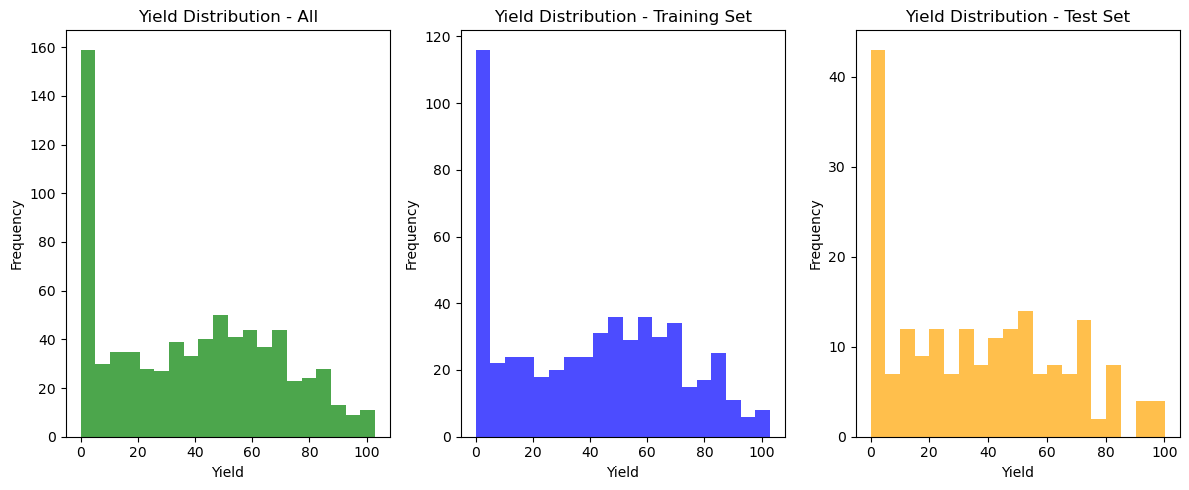

In [18]:
yield_training = df_training['answer']
yield_test = df_test['answer']
yield_prompts = prompts_df['answer']

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].hist(yield_prompts, bins=20, color='green', alpha=0.7)
axs[0].set_title('Yield Distribution - All')
axs[0].set_xlabel('Yield')
axs[0].set_ylabel('Frequency')

axs[1].hist(yield_training, bins=20, color='blue', alpha=0.7)
axs[1].set_title('Yield Distribution - Training Set')
axs[1].set_xlabel('Yield')
axs[1].set_ylabel('Frequency')

axs[2].hist(yield_test, bins=20, color='orange', alpha=0.7)
axs[2].set_title('Yield Distribution - Test Set')
axs[2].set_xlabel('Yield')
axs[2].set_ylabel('Frequency')



plt.tight_layout()
plt.show()

### 1.2.3 Few-shot examples

In [19]:
def select_reactions_by_yield(df):
    low_yield = df_training[(df_training['answer'] >= 0) & (df_training['answer'] <= 30)].sample(n=2, random_state=42)
    medium_yield = df_training[(df_training['answer'] > 30) & (df_training['answer'] <= 70)].sample(n=2, random_state=42)
    high_yield = df_training[(df_training['answer'] > 70) & (df_training['answer'] <= 100)].sample(n=2, random_state=42)

    selected_reactions = pd.concat([low_yield, medium_yield, high_yield], ignore_index=True)
    
    return selected_reactions

In [20]:
df_few_shot_6 = select_reactions_by_yield(df_training)
print(df_few_shot_6)

                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07


### 1.2.4 Causal reasoning stimulation

In [49]:
counterfactual_questions = [
"In an effort to assess causal relationships between variables, please answer the following counterfactual questions with concise answers:",

"1. How would the reaction yield change if reactant 2 was not a halide?",
"2. How would the reaction yield change if reactant 1 was not an amine?",
"3. How would the reaction yield change if the solvent was replaced by a polar solvent like water?",
"4. How would the reaction yield change if the base was removed?",
"5. How would the reaction yield change if the reaction temperature was set at -78°C?",
"6. How would the reaction yield change if the metal catalyst amount was changed?",
"7. How would the reaction yield change if the amine reactant amount was changed?",
"8. How would the reaction yield change if the halide reactant amount was changed?",
"9. How would the reaction yield change if the reaction volume was extremely small or big?",
"10. How would the reaction yield change if the ligand amount was set to 0 or in the contrary increased to high levels?",
"11. How would the reaction yield change if both the amine and the halide molecular weights were much smaller or bigger?",
"12. How would the reaction yield change if both the amine and the halide molecular volume were much smaller or bigger?",
"13. How would the reaction yield change if both the amine and the halide surface area were much smaller or bigger?",
"14. How would the reaction yield change if both the amine and the halide ovality were much smaller or bigger?",
"15. How would the reaction yield change if both the amine and the halide hardness were much smaller or bigger?",
"16. How would the reaction yield change if both the amine and the halide dipole moment were much smaller or bigger?",
"17. How would the reaction yield change if both the amine and the halide electronegativity were much smaller or bigger?",
"18. How would the reaction yield change if both the amine and the halide E HOMO and E LUMO were much smaller or bigger?",
"19. How would the reaction yield change if both the amine and the halide C1 electrostatic charge were much smaller or bigger?",
"20. How would the reaction yield change if both the amine and the halide N1 NMR shift were much smaller or bigger?",
"21. How would the reaction yield change if the halide V0, V1, and V2 frequencies and intensities were much smaller or bigger?",
"22. How would the reaction yield change if the halide C2 electrostatic charges were much smaller or bigger?",
"23. How would the reaction yield change if the halide C2 NMR shift were much smaller or bigger?",
"24. How would the reaction yield change if the ligand molecular weight was much smaller or bigger?",
"25. How would the reaction yield change if the ligand dipole moment was much smaller or bigger?",
"26. How would the reaction yield change if the ligand electronegativity was much smaller or bigger?",
"27. How would the reaction yield change if the ligand E HOMO and E LUMO were much smaller or bigger?",
"28. How would the reaction yield change if the ligand P1 electrostatic charge was much smaller or bigger?",
"29. How would the reaction yield change if the ligand P1 NMR shift was much smaller or bigger?",
]


## 1.3 API calls

### 1.3.1 Function definitions

In [22]:
import openai
from openai import OpenAI

import requests
import re

In [23]:
client = OpenAI(api_key='')

In [24]:
class ChatGPTModel:
    def __init__(self, api_key):
        self.api_key = api_key
        self.endpoint = "https://api.openai.com/v1/chat/completions"
        self.conv_history = []  

    def generate_response(self, prompt):
        """
        Sends the prompt (including conversation history) to the API and returns the response.
        """
        full_prompt = "\n".join(self.conv_history + [prompt])  
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }
        data = {
            "model": "gpt-4o-mini",  
            "messages": [{"role": "user", "content": full_prompt}],
            "max_tokens": 10,  
            "temperature": 0.7
        }
        response = requests.post(self.endpoint, headers=headers, json=data)

       
        try:
            response_json = response.json()
            print(f"Full API Response: {response_json}")  
            return response_json['choices'][0]['message']['content']
        except KeyError as e:
            print(f"Error extracting response: {e}")
            return None  

    def update_conversation_history(self, user_input, response):
        """
        Updates the conversation history with the user input and the model's response.
        """
        self.conv_history.append(f"User: {user_input}")
        self.conv_history.append(f"Bot: {response}")





In [25]:
def run_pipeline(api_key, test_set, percentages, few_shot_examples):
    chat_model = ChatGPTModel(api_key)

    for focus_percentage in percentages:
        chat_model.conv_history = []  

        column_name = []

        column_name = f"yield_pred_{focus_percentage}"

        intro_prompt = (
            f"You are an expert at organic chemistry reaction and causal reasoning. "
            f"Here are a few examples of question-answer I want you to learn from:\n{few_shot_examples}\n"
            "I will then ask you a few questions on counterfactual statements to stimulate your causal reasoning ability."
        )
        response_intro = chat_model.generate_response(intro_prompt)
        chat_model.update_conversation_history(intro_prompt, response_intro)

        counterfactual_prompt = "\n".join(counterfactual_questions)
        response_counterfactual = chat_model.generate_response(counterfactual_prompt)
        chat_model.update_conversation_history(counterfactual_prompt, response_counterfactual)

        understanding_prompt = (
            f"Now that you have established the relationship between variables in this dataset and understand them, "
            f"I would like to test you on some test questions about yield prediction of chemical reactions. "
            f"It is crucial that you remember our training on causality and pay {focus_percentage}% of your attention "
            f"to this new thought process with respect to your normal deductive reasoning approach."
        )
        response_understanding = chat_model.generate_response(understanding_prompt)
        chat_model.update_conversation_history(understanding_prompt, response_understanding)

        for index, row in test_set.iterrows():
            test_question = (
                f"What would the yield of the following reaction be? "
                f"Please answer with only the yield % number and nothing else: {row['Prompts']}"
            )
            
            full_prompt = "\n".join(chat_model.conv_history + [test_question])
            response_test = chat_model.generate_response(full_prompt)   

            test_set.at[index, column_name] = response_test

            print(f"Index: {index}, Question: {test_question}, Response: {response_test}")
           

    return test_set


In [26]:
def run_pipeline_new(api_key, test_set, percentages, few_shot_examples):
    chat_model = ChatGPTModel(api_key)

    for focus_percentage in percentages:
        chat_model.conv_history = []  

        column_name = []

        column_name = f"yield_pred_{focus_percentage}"

        intro_prompt = (
            f"You are an expert at organic chemistry reaction and causal reasoning. "
            f"Here are a few examples of question-answer I want you to learn from:\n{few_shot_examples}\n"
           
        )
        response_intro = chat_model.generate_response(intro_prompt)
        chat_model.update_conversation_history(intro_prompt, response_intro)

        if focus_percentage == 0:

            print("No counterfactual reasoning.")

        else:
            counterfactual_prompt = "\n".join(counterfactual_questions)
            response_counterfactual = chat_model.generate_response(counterfactual_prompt)
            chat_model.update_conversation_history(counterfactual_prompt, response_counterfactual)

            understanding_prompt = (
                f"Now that you have established the relationship between variables in this dataset and understand them, "
                f"I would like to test you on some test questions about yield prediction of chemical reactions. "
                f"It is crucial that you remember our training on causality and pay {focus_percentage}% of your attention "
                f"to this new thought process with respect to your normal deductive reasoning approach."
            )
            response_understanding = chat_model.generate_response(understanding_prompt)
            chat_model.update_conversation_history(understanding_prompt, response_understanding)

        for index, row in test_set.iterrows():
            test_question = (
                f"What would the yield of the following reaction be? "
                f"Please answer with only the yield % number and nothing else: {row['Prompts']}"
            )
            
            count = 0

            full_prompt = "\n".join(chat_model.conv_history + [test_question])
            response_test = chat_model.generate_response(full_prompt)

            while count < 5:
                extracted_value = extract_float_from_response(response_test)
    
                if isinstance(extracted_value, (float, int)):  
                    test_set.at[index, column_name] = extracted_value
                    break

                if count == 4:  
                    test_set.at[index, column_name] = response_test
                    break

                count += 1

            
            print(f"Index: {index}, Question: {test_question}, Response: {test_set.at[index, column_name]}")

    return test_set


In [27]:
def extract_float_from_response(response):

    match = re.search(r"[-+]?\d*\.\d+|\d+", response)
    
    if match:
        return float(match.group())
    else:
        return np.nan 


In [28]:
def get_chatgpt_response_priming_causal(row, str_fs, str_causal):
    
    try:
        
        user_message = (
            f"Provide only the SMILES representation for the following question, without any explanation or extra text:\n\n"
            f"This is the few-shot training you can use:\n\n"
            f"{str_fs}\n\n"
            f"I also want you to understand the causal realtionship between variables:\n\n"
            f"{str_causal}\n\n"
            f"Now, for the new question:\n\n"
            f"Q: {row}\nA:"
        )
      
        response = client.chat.completions.create( 
            model="gpt-4o-mini",  
            messages=[
                {"role": "system", "content": "You are an expert in organic chemistry specialized in aldol-type chemical reactions and you are also an expert in understanding causal relationships between variables"},
                {"role": "user", "content": user_message}
            ],
            max_tokens=100,  
            temperature=0.15 
        )
        
        return response.choices[0].message.content.strip()

    except Exception as e:
        return f"Error: {str(e)}"

In [29]:
def extract_numeric(cell_value):

    match = re.search(r"[-+]?\d*\.\d+|\d+", str(cell_value))
    if match:
        return float(match.group())  
    else:
        return np.nan  

In [30]:
def categorize_yield(yield_value):
    if pd.isna(yield_value):  # Check for NaN
        return "NaN"  
    elif yield_value < 30:
        return 0  
    elif yield_value <= 70:
        return 1  
    else:
        return 2

In [31]:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

In [32]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

### 1.3.2 Classification task

# 2. Langchain Memory Agent approach on test questions


## 2.1 SMILES & extra features dataset - Causal stimulation on few-shot examples

In [33]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [34]:
from langchain.llms import OpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI

In [35]:
api_key=''

In [46]:
def run_pipeline_langchain_new(api_key, test_set, percentages, few_shot_examples, temp):

    for focus_percentage in percentages:
        
        llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=temp, openai_api_key=api_key)
        memory = ConversationBufferMemory()

        conversation = ConversationChain(
            llm=llm, 
            memory=memory
        )

        column_name = f"yield_pred_{focus_percentage}" 
        test_set.loc[:, column_name] = pd.Series(dtype='float')

        intro_prompt = (
            f"You are an expert at organic chemistry on Buchwald-Hartwig reactions and causal reasoning. "
            f"Here are a few examples of question-answer I want you to learn from:\n{few_shot_examples}\n"
            
        )
        response_intro = conversation.predict(input=intro_prompt)  # few-shot learning
        print(f"Introductory Response: {response_intro}")

        for index, row in test_set.iterrows():
         
            if focus_percentage == 0:
                print("No causal question asked")

                test_question = (
                f"What would the yield of the following reaction be? "
                f"Please answer with only the yield % number and nothing else: {row['Prompts']}"
                )

                conversation_history = "\n".join([msg.content for msg in memory.chat_memory.messages])
                full_prompt = conversation_history + f"\n{test_question}"

                response_test = conversation.llm.predict(full_prompt) 
            
                test_set.at[index, column_name] = response_test

            else:
                counterfactual_prompt = "\n".join(counterfactual_questions)

                causal_understanding = (
                    "I will now ask you to predict the yield of a reaction I will provide you with, but before that, you will need to perform some counterfactual causal reasoning on the test question before trying to predict the answer"
                    f"Ask yourself the following questions {counterfactual_prompt} \n on the following case: {row['Prompts']}"
                )

                response_understanding = conversation.llm.predict(causal_understanding)

                print(f"Understanding Causality Response: {response_understanding}")
                
                test_question = (
                f"It is crucial that you remember causality aspect and pay {focus_percentage}% of your attention on the prediction to this new thought process with respect to your normal deductive reasoning approach."
                f"Predict now the yield of the reaction {row['Prompts']} that you just reasoned on"
                )

                conversation_history = "\n".join([msg.content for msg in memory.chat_memory.messages])
                full_prompt = conversation_history + f"\n{response_understanding}" + f"\n{test_question}"

                response_test = conversation.llm.predict(full_prompt) 
            
                test_set.at[index, column_name] = response_test
                
            print(f"Index: {index}, Question: {full_prompt}, Response: {response_test}")

    return test_set


In [37]:
df_test.columns

Index(['Prompts', 'answer'], dtype='object')

In [38]:
df_test_langchain = df_test[['Prompts', 'answer']]

In [44]:
temp = [0.1, 0.4, 0.7, 0.9]
percentages = [0, 25, 50, 75, 100]

In [48]:
df_runs_07 = []
n_runs = 5

for i in range(n_runs):
        print(f"Run {i+1}/{n_runs}")
        df_results_langchain_07 = run_pipeline_langchain_new(api_key, df_test_langchain.head(1), percentages, df_few_shot_6, 0.7)
        df_runs_07.append(df_results_langchain_07)

Run 1/5


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:, column_name] = pd.Series(dtype='float')


Introductory Response: Thank you for sharing those examples! It looks like you're interested in understanding how the yield of organic chemistry reactions can vary based on different conditions or reactants. Each yield percentage corresponds to specific factors such as reaction conditions, the nature of the reactants, catalyst presence, and the method of purification. 

If you have a specific reaction in mind or particular variables you'd like to discuss, feel free to ask! I'd be happy to help you analyze it or provide more details about the factors that might influence the yield.
No causal question asked


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_set.at[index, column_name] = response_test
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:, column_name] = pd.Series(dtype='float')


Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding how the yield of organic chemistry reactions can vary based on different conditions or reactants. Each yield percentage corresponds to specific factors such as reaction conditions, the nature of the reactants, catalyst presence, and the method of purification. 

If you have a specific reaction in mind or particular variabl

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the provided reactants and conditions, let's analyze the information systematically. 

### Key Factors Affecting Yield:

1. **Reactants Involved**:
   - **Amine (Reactant 1)**: C1CC1CNC2=CC=C(C3=CC=CC=C32)Cl
   - **Halide (Reactant 2)**: CCOC(=O)C1CC1C(=O)C2=C(C=C(C=N2)Br)OC

   The presence of both an amine and a halide is crucial for a nucleophilic substitution reaction. Both reactants have relatively complex structures, which may affect the reaction kinetics and yield.

2. **Solvent**: CC1=CC=CC=C1 (likely a hydrocarbon solvent)
   - The choice of solvent can significantly affect the solubility and reactivity of the reactants. Hydrocarbon solvents may not solvate ionic species well, which could hinder the reaction.

3. **Base**: C(=

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! They seem to focus on calculating the yield of various organic chemistry reactions. Yield can be influenced by several factors, including the reaction conditions, the purity of reactants, and the reaction's equilibrium. If you have any specific questions or scenarios you'd like to discuss regarding reaction yields or organic chemistry in general, feel free to ask! I'm he

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction given the detailed information about the reactants, solvent, base, metal catalyst, ligand, and specific parameters, we can analyze the factors influencing the yield based on the data and reasoning you've provided.

### Key Factors to Consider:

1. **Reactants**:
   - **Amine (Reactant 1)**: The presence of the amine is crucial as it acts as a nucleophile. The specified amount (0.0012) is relatively small, but the molecular weight (-1.0) seems to be an error since molecular weights are usually positive. The molecular volume (271.23) and surface area (615.60) are reasonable, suggesting good molecular interaction potential.
   - **Halide (Reactant 2)**: The halide has a significant molecular weight (328.16) and volume (310.39), indicating it is sub

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like they provide information on the yields of different organic chemistry reactions. Each yield percentage likely corresponds to specific reaction conditions, substrates, or catalysts involved in those reactions. If you have any specific questions about organic chemistry reactions, yield calculations, or causal reasoning in this context, feel free to ask! I’m h

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the specified reactants, solvent, base, metal catalyst, and ligand, I will analyze the provided parameters based on the principles of organic chemistry and the influence of various factors on reaction yield.

### Key Factors:
1. **Reactant Properties**:
   - **Amine (Reactant 1)**: 
     - Molecular weight: -1.0 (possibly an error, but high molecular weight can usually influence yield positively due to stability).
     - Molecular volume: 271.23215 (moderate).
     - Surface area: 615.60187 (high surface area typically favors reaction).
     - Dipole moment: 4.4458 (high polarity can enhance nucleophilicity).
   - **Halide (Reactant 2)**:
     - Molecular weight: 328.16 (significant).
     - High surface area and dipole moment (3.3523)

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding the yields of various organic chemistry reactions. The yield of a reaction can be influenced by several factors, including the reaction conditions (such as temperature and pressure), the purity of the reactants, and the presence of catalysts.

If you have specific reactions in mind or particular conditions you'd like to di

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction given the various parameters and reactants involved, let's analyze the situation based on the factors that influence reaction yields in organic chemistry.

### Key Factors to Consider:

1. **Reactants**:
   - **Amine (Reactant 1)**: The presence of an amine is crucial for nucleophilic attack. Given its molecular weight and volume, it's relatively large but could still be reactive.
   - **Halide (Reactant 2)**: This is an electrophile and its characteristics (like molecular weight and dipole moment) suggest it could be a good leaving group.

2. **Catalysts and Ligands**:
   - **Metal Catalyst**: There is no metal catalyst mentioned in the reaction, which could lead to a decrease in yield since catalysts often enhance reaction rates and yield.
   

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in the yields of various organic chemistry reactions. The yield of a reaction can depend on several factors, including the specific reactants involved, reaction conditions (like temperature and pressure), catalysts used, and even the purity of the starting materials. 

If you have specific reactions in mind or any particular conditions you

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_set.at[index, column_name] = response_test
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:, column_name] = pd.Series(dtype='float')


Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! They show a range of potential yields for organic chemistry reactions, which can vary based on numerous factors such as reaction conditions, reagents used, and the presence of catalysts. 

In organic chemistry, the yield of a reaction is often influenced by factors like temperature, pressure, solvent choice, and the purity of starting materials. For instance, higher temp

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction based on the provided information, we will consider the roles of each component (reactants, solvent, base, ligand, and temperature) and their potential impact on the reaction yield.

### Key Factors Affecting the Yield:

1. **Reactants**:
   - **Reactant 1 (Amine)**: Present in a reasonable amount (0.0012). The structure suggests it could effectively participate in nucleophilic substitution.
   - **Reactant 2 (Halide)**: Also present in a sufficient amount (0.001). Halides typically enhance reactivity in nucleophilic reactions.
   
2. **Solvent**: 
   - The solvent is a cyclohexene derivative (CC1=CC=CC=C1), which is generally non-polar and may not provide good solvation for polar reactants. This can affect the reaction kinetics.

3. **Base**:
 

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Got it! It looks like you're interested in yields of organic chemistry reactions, which can depend on various factors such as reaction conditions, reactant concentrations, and catalysts. If you have specific reactions in mind, feel free to ask, and I can provide insights or calculations based on the information you provide!
To provide a prediction on the yield of the reaction based on the provided informatio

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the specified reactants, we can analyze the provided information and consider the factors that might influence the yield based on causal reasoning.

1. **Reactants and Their Properties**:
   - **Reactant 1 (Amine)**: It has a relatively low molecular weight (-1.0, which is unconventional as molecular weights are generally positive) and a significant dipole moment (4.4458), indicating good polarity, which can help in solvation and reactivity.
   - **Reactant 2 (Halide)**: It has a higher molecular weight (328.16) and notable surface area and dipole moment values, which suggest it is a larger, more complex molecule that may have steric hindrance but also good reactivity due to electronegativity (0.14606).

2. **Conditions**:
   - **Tempe

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like they pertain to the yields of various reactions in organic chemistry, which can be influenced by numerous factors like reaction conditions, the nature of the reactants, catalysts, and more. If you have any specific questions about organic chemistry reactions or if you want to discuss how to calculate yields or interpret results, feel free to ask! I'm here t

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the provided reactants, solvent, base, metal catalyst, and ligand, we need to analyze the key factors influencing the reaction based on the information provided. Here are some considerations:

1. **Reactants**:
   - **Amine Reactant (C1CC1CNC2=CC=C(C3=CC=CC=C32)Cl)**:
     - The properties suggest a relatively bulky structure with a suitable nucleophilic character due to the amine group.
   - **Halide Reactant (CCOC(=O)C1CC1C(=O)C2=C(C=C(C=N2)Br)OC)**:
     - The presence of the halide indicates that it can participate in nucleophilic substitution, which is essential for this reaction.

2. **Solvent**:
   - The solvent is a cyclic alkene (CC1=CC=CC=C1), which may help in solubilizing the reactants effectively. This should promote bette

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in discussing the yields of various organic chemistry reactions. The yield of a reaction can be influenced by numerous factors, such as the reaction conditions, the purity of reactants, temperature, catalysts, and the reaction mechanism involved. 

If you have specific reactions or conditions in mind, feel free to share them, and I can hel

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the provided reactants, solvent, base, metal catalyst, and ligand, we should consider several factors based on the information given. Here's a breakdown of the relevant components and conditions:

### Key Factors Influencing Yield:

1. **Reactants**:
   - **Amine (Reactant 1)**: C1CC1CNC2=CC=C(C3=CC=CC=C32)Cl
     - Molecular weight and surface area suggest reasonable reactivity.
   - **Halide (Reactant 2)**: CCOC(=O)C1CC1C(=O)C2=C(C=C(C=N2)Br)OC
     - Its relatively high molecular weight may slow down the reaction.

2. **Solvent**:
   - Solvent used is non-polar (CC1=CC=CC=C1).
   - Non-polar solvents may enhance solubility for the organic reactants.

3. **Reaction Conditions**:
   - **Temperature**: 70°C is moderate for many organic

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Got it! It looks like you want to explore organic chemistry reactions and their yields based on various prompts. The yields you provided vary significantly, which suggests that they might be influenced by factors such as reaction conditions, the nature of the reactants, catalysts, temperature, and solvent choice. If you have any specific reactions in mind or further examples, feel free to share! I'm here to 

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42.50' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_set.at[index, column_name] = response_test
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:, column_name] = pd.Series(dtype='float')


Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're providing a series of prompts related to the yield of various organic chemistry reactions. Each prompt corresponds to a specific yield value, which likely reflects the efficiency of the reactions under certain conditions. 

In organic chemistry, the yield of a reaction can be influenced by several factors, such as the choice of reagents, reaction con

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the provided reactants, solvents, base, metal catalyst, and ligand, we can consider the various factors that influence the reaction yield based on the details given. Here’s a structured analysis:

### Factors Influencing Yield:

1. **Reactants**:
   - **Amine (Reactant 1)**: The molecular weight is negative (-1.0), which is unusual and may indicate an error. However, its substantial molecular volume (271.23) and surface area (615.60) suggest good reactivity.
   - **Halide (Reactant 2)**: Higher molecular weight (328.16) may slow reaction kinetics but its properties (dipole moment, electronegativity) are favorable for nucleophilic substitution.

2. **Solvent**: 
   - The solvent appears to be a non-polar solvent (CC1=CC=CC=C1), which mi

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Got it! It looks like you’re interested in understanding the yields of various organic chemistry reactions based on specific prompts. The yields can vary significantly depending on the conditions, reagents, and mechanisms involved in each reaction. 

If you have specific reactions or conditions in mind, feel free to share! I can provide insights on what factors might affect the yield or any other relevant de

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the provided reactants and conditions, we need to analyze various factors based on the information given. Here’s a structured reasoning approach, incorporating both causal reasoning and the specific parameters provided.

1. **Reactants**:
   - **Reactant 1 (Amine)**: C1CC1CNC2=CC=C(C3=CC=CC=C32)Cl
     - Presence of a cyclic amine and a Cl substituent suggests potential nucleophilicity and reactivity.
   - **Reactant 2 (Halide)**: CCOC(=O)C1CC1C(=O)C2=C(C=C(C=N2)Br)OC
     - Contains a Br substituent which is a good leaving group.

2. **Solvent**:
   - The solvent (CC1=CC=CC=C1) is a non-polar aromatic compound, which generally favors reactions involving organic reactants but may limit solubility if polar components are involved.

3. *

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding the yields of specific organic chemistry reactions. In organic chemistry, the yield of a reaction can be influenced by several factors such as the reaction conditions, the purity of the reactants, and the efficiency of the catalyst used, among others. 

If you have specific reactions in mind, feel free to ask! I can help e

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the provided reactants and conditions, we need to analyze the factors influencing the yield systematically. 

### Key Factors to Consider

1. **Reactants**:
   - **Amine (Reactant 1)**: C1CC1CNC2=CC=C(C3=CC=CC=C32)Cl
     - Molecular weight: -1.0 (possibly an error, as molecular weights should be positive)
     - Volume: 271.23
     - Surface area: 615.60
     - Dipole moment: 4.45 (indicating polarity, which can enhance solubility and reactivity)
   - **Halide (Reactant 2)**: CCOC(=O)C1CC1C(=O)C2=C(C=C(C=N2)Br)OC
     - Molecular weight: 328.16 (this is a suitable size for reactivity)
     - Volume: 310.39
   - The halide is essential for nucleophilic substitution, and the presence of both reactants is crucial for product formation.



Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding the yields of different organic chemistry reactions. Yield can be influenced by various factors such as reaction conditions, the nature of the reactants, catalysts, temperature, and time. 

If you have specific reactions in mind or any particular questions about how to calculate or predict yields, feel free to ask! I'm her

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the provided reactants and conditions, we will analyze the various factors that could influence the outcome based on the information provided. Here’s a breakdown of the key aspects to consider:

### Reactants and Their Properties:
1. **Amine (Reactant 1)**:
   - Amount: 0.0012 mol
   - Molecular weight: -1.0 (seems like an error, should be positive)
   - Molecular volume: 271.23
   - Surface area: 615.60
   - Dipole moment: 4.45 (high dipole moment indicates good nucleophilicity)
   - E HOMO/LUMO: Favorable values for reactivity.

2. **Halide (Reactant 2)**:
   - Amount: 0.001 mol
   - Molecular weight: 328.16
   - High surface area and dipole moment, which suggests good electrophilicity.

### Other Influencing Factors:
3. **Base**:
  

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding the yields of various organic chemistry reactions. Yield can be influenced by numerous factors, such as reaction conditions, the purity of reactants, catalysts used, and even temperature. If you have specific reactions or conditions in mind, feel free to share them, and I can help you reason through what the yield might be

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_set.at[index, column_name] = response_test
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:, column_name] = pd.Series(dtype='float')


Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in the yield of various organic chemistry reactions. The yield can depend on several factors, including the reaction conditions, the nature of the reactants, catalysts used, and the efficiency of the process. If you have specific reactions in mind or if you'd like to discuss how certain factors influence yield, feel free to ask! I'm here t

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the given reaction involving the specified reactants, solvent, base, metal catalyst, and ligand, we can analyze the provided information, focusing on the key factors influencing yield. 

### Key Factors:
1. **Presence of Reactants**: 
   - **Amine (reactant 1)**: Present in a reasonable amount (0.0012) and has key properties like a dipole moment (4.4458) that suggest it's a good nucleophile.
   - **Halide (reactant 2)**: Also present (0.001), with properties that suggest it can act as a good electrophile.

2. **Base**: 
   - Present at 0.00241, which is generally crucial for deprotonating the amine or activating the halide.

3. **Metal Catalyst**: 
   - The amount is very low (5e-05), and since it is specified as "None", we can assume the reaction may be lim

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding the yields of various organic chemistry reactions. Yield can be influenced by several factors, including the reaction conditions, the purity of the reactants, and the efficiency of the catalysts used. 

If you have specific reactions in mind or particular conditions you want to explore, feel free to ask! I can help you ana

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction given the detailed parameters and conditions you provided, let's analyze the key components and their potential impact on the reaction yield based on the causal reasoning framework outlined earlier.

### Key Considerations:

1. **Reactants**: 
   - **Amine (Reactant 1)**: 
     - Amount: 0.0012 moles
     - Molecular Weight: -1.0 (This appears to be an erroneous value; molecular weight cannot be negative.)
     - Dipole Moment: 4.4458 (This indicates polarity, which could enhance reactivity.)
     - E HOMO and E LUMO values indicate its potential to act as a nucleophile.
   - **Halide (Reactant 2)**: 
     - Amount: 0.001 moles
     - Molecular Weight: 328.16 (This is typical for halides.)
     - E HOMO and E LUMO values indicate its potential t

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Got it! It looks like you want to understand how to estimate the yield of various organic chemistry reactions based on certain prompts. Each prompt corresponds to a specific reaction, and the yields vary quite a bit. 

In organic chemistry, yield can depend on numerous factors, including the reaction conditions (like temperature and pressure), the purity of the reactants, the presence of catalysts, and the r

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction based on the provided information, we will analyze various factors that may influence the yield. Given the complexity of the reaction and the numerous conditions, I'll systematically assess the relevant parameters.

1. **Reactants**:
   - **Reactant 1 (Amine)**: 
     - The molecular properties (volume, surface area, dipole moment, etc.) suggest it has a substantial size and significant polarity. The molecular weight is notably negative, which may indicate an unusual consideration, but the overall reactivity depends on the structure.
   - **Reactant 2 (Halide)**: 
     - This reactant has a considerable molecular weight and volume, which might affect the sterics of the reaction. The presence of a halide suggests a potential for nucleophilic subs

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in the yields of certain organic chemistry reactions. Yields can depend on various factors, including the nature of the reactants, the reaction conditions, and the efficiency of the catalytic process, among others. 

If you have specific reactions in mind or want to explore how to calculate yields based on different scenarios, feel free to

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the provided reactants, solvent, base, metal catalyst, and ligand, we need to analyze the various factors that can influence the yield based on the information given.

### Factors Influencing Yield

1. **Presence of Key Reactants:**
   - **Amine (Reactant 1)**: Present in sufficient quantity (0.0012), which is crucial for nucleophilic attack.
   - **Halide (Reactant 2)**: Also present (0.001), serving as the electrophile and leaving group.
  
2. **Base**: The amount of base (0.00241) suggests it’s adequately present to deprotonate the amine or activate the reaction.

3. **Metal Catalyst**: The amount is very low (5e-05). While this could be detrimental if the catalyst is essential for the reaction, it may still facilitate some reaction

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding the yields of various organic chemistry reactions. Yield is an important concept in organic chemistry, as it indicates the efficiency of a reaction by showing how much product is formed relative to the theoretical maximum. 

If you have specific reactions in mind or variables that you want to consider, feel free to ask! I 

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_set.at[index, column_name] = response_test
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:, column_name] = pd.Series(dtype='float')


Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding the yields of various organic chemistry reactions. Yields can be influenced by a variety of factors, including reaction conditions, the nature of the reactants, and the presence of catalysts. 

If you have specific reactions in mind or want to explore factors that can affect yield, feel free to ask! I can also help explain

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the specified reactants, solvent, base, metal catalyst, and ligand, we should analyze the provided parameters and their potential impact on the reaction yield.

**Key Factors to Consider:**

1. **Reactant Concentrations:**
   - **Amine (Reactant 1):** 0.0012 mol
   - **Halide (Reactant 2):** 0.001 mol
   - The amine is in excess relative to the halide, which is favorable for the reaction yield.

2. **Metal Catalyst:**
   - The amount of metal catalyst is very small (5e-05 mol). While catalysts are crucial for reaction efficiency, this low concentration may hinder the reaction if it is not sufficient to facilitate the desired transformation.

3. **Base Concentration:**
   - A base amount of 0.00241 mol is present, which should help in d

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like you're interested in understanding the yields of various organic chemistry reactions. The yield of a reaction can depend on a variety of factors, such as the reaction conditions (temperature, pressure), the purity of the starting materials, the presence of catalysts, and even the reaction time. 

If you have specific reactions in mind, I’d be happy to discu

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction given the detailed information about the reactants, solvent, base, metal catalyst, and ligand, we need to consider several factors, including the nature of the reactants, the reaction conditions, and the potential influences of various parameters.

### Key Factors:

1. **Reactants**:
   - **Amine (Reactant 1)**: The molecular weight is negative, which suggests it might be an unconventional measurement or a placeholder. The molecular volume and surface area are reasonably large, which could indicate a bulky structure. The dipole moment and electronegativity also suggest some polarity, which could aid in reactivity.
   - **Halide (Reactant 2)**: The halide has a significant molecular weight and volume, along with a positive electrostatic charge on

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Thank you for sharing those examples! It looks like they involve predicting the yield of various organic chemistry reactions. The yields you've listed seem to vary quite a bit, which is typical since reaction yields can be influenced by numerous factors, including the nature of the reactants, reaction conditions (like temperature and pressure), catalysts, and the purity of the starting materials.

If you hav

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction involving the specified reactants, solvent, base, metal catalyst, and ligand, we can analyze the provided information while considering various factors that influence reaction yield. 

### Factors Influencing Yield:

1. **Reactant Characteristics**: 
   - Reactant 1 (Amine) has a relatively low molecular weight (-1.0) and a high surface area (615.60187). However, its molecular weight being negative seems unusual, potentially indicating an error. The dipole moment (4.4458) suggests good polarity, which is beneficial for nucleophilic reactions.
   - Reactant 2 (Halide) has a higher molecular weight (328.16) and surface area (661.48578), suggesting it could serve as a decent leaving group due to its size and electronegativity (0.14606).

2. **React

Index: 506, Question: You are an expert at organic chemistry reaction and causal reasoning. Here are a few examples of question-answer I want you to learn from:
                                             Prompts  answer
0  What would be the yield of the reaction involv...    0.00
1  What would be the yield of the reaction involv...   23.08
2  What would be the yield of the reaction involv...   45.70
3  What would be the yield of the reaction involv...   42.50
4  What would be the yield of the reaction involv...   84.95
5  What would be the yield of the reaction involv...   75.07

Got it! It looks like you're interested in understanding the yields of various organic chemistry reactions. The yield of a reaction can depend on many factors, such as the reaction conditions, the purity of reactants, and even the presence of catalysts. If you have specific reactions in mind or want to discuss how to optimize yields, feel free to share! I'm here to help with any questions you might have.
To 

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/5977817.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'To predict the yield of the reaction given the details provided, we can analyze several factors that influence the yield based on the properties of the reactants, solvent, base, ligand, and the reaction conditions. 

### Key Factors Influencing Yield

1. **Reactants**:
   - **Amine (Reactant 1)**: The presence of the amine is crucial as it acts as a nucleophile. The provided molecular weight and volume seem reasonable for typical amines. However, the electronegativity and dipole moment suggest it is a moderately reactive amine.
   - **Halide (Reactant 2)**: The halide has a relatively high molecular weight and surface area, which could indicate steric hindrance. However, its electronegativity and dipole moment suggest it could still function as a good leaving group.

2. **Solvent**

In [51]:
name = pd.concat(df_runs_07, axis=0, keys=range(n_runs))

temp_df = name.applymap(extract_numeric)

temp_df_1 = temp_df.groupby(level=1).mean()

temp_df_2 = temp_df.agg(['mean', 'std'])



/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_5292/2483192225.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = name.applymap(extract_numeric)


In [ ]:
for t in temp:

    df_runs = []

    dfs = []

    n_runs = 5

    count = 0

    for i in range(n_runs):
        print(f"Run {i+1}/{n_runs}")
        df_results_langchain = run_pipeline_langchain(api_key, df_test_langchain.head(1), percentages, df_few_shot_6, t)
        df_runs.append(df_results_langchain)

        name = f"df_combined_{count}"

        count += 1

        name = pd.concat(df_runs, axis=0, keys=range(n_runs))

        temp_df = name.applymap(extract_numeric)

        temp_df_1 = temp_df.groupby(level=1).mean()

        temp_df_2 = temp_df.agg(['mean', 'std'])

        dfs.append(temp_df_1)


In [ ]:
dfs

At this point, change manually the df variable for the moment

In [669]:
df_cat_lc = pd.DataFrame()

df_cat_lc['true_category'] = df_extracted_0['answer'].apply(categorize_yield)

prediction_columns = ['yield_pred_0', 'yield_pred_25', 'yield_pred_50', 'yield_pred_75', 'yield_pred_100']

for col in prediction_columns:
    
    df_cat_lc[f"category_{col}"] = df_extracted_01[col].apply(categorize_yield)


In [670]:
df_cat_lc

,true_category,category_yield_pred_0,category_yield_pred_25,category_yield_pred_50,category_yield_pred_75,category_yield_pred_100
2,1,1,1,1,1,1
6,1,1,1,1,1,1
7,1,1,1,1,1,1
10,1,0,1,1,1,0
23,1,1,1,1,1,1
...,...,...,...,...,...,...
737,0,0,0,0,0,0
740,1,0,0,0,0,0
744,0,1,1,1,1,1
745,1,0,0,0,0,0


In [671]:
print((df_cat_lc == "NaN").sum())

true_category              0
category_yield_pred_0      0
category_yield_pred_25     0
category_yield_pred_50     0
category_yield_pred_75     0
category_yield_pred_100    0
dtype: int64


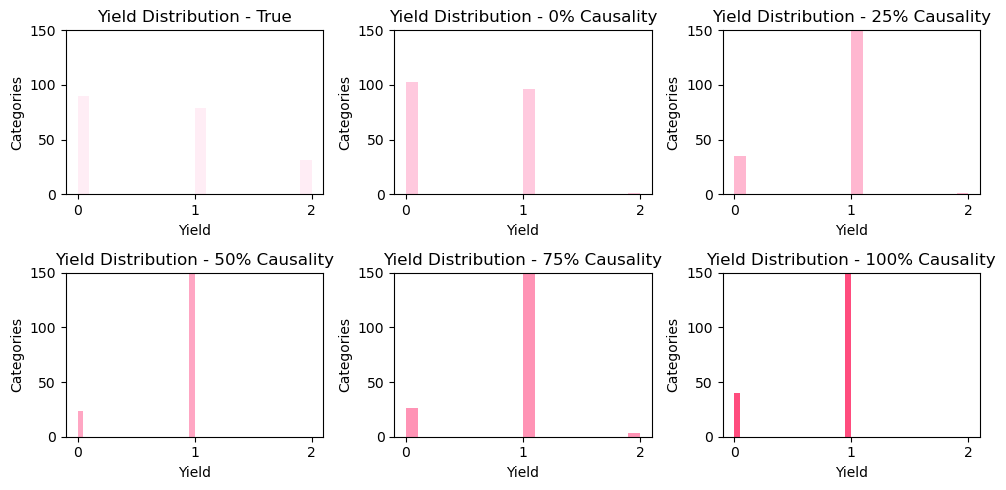

In [672]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

x_limits = [-0.1, 2.1]  
y_limits = [0, 150] 
x_ticks = [0, 1, 2]

axs[0][0].hist(df_cat_lc[df_cat_lc.columns[0]], bins=20, color='#FFE6F2', alpha=0.7)
axs[0][0].set_title('Yield Distribution - True')
axs[0][0].set_xlabel('Yield')
axs[0][0].set_ylabel('Categories')
axs[0][0].set_xlim(x_limits)
axs[0][0].set_ylim(y_limits)
axs[0][0].set_xticks(x_ticks)


axs[0][1].hist(df_cat_lc[df_cat_lc.columns[1]], bins=20, color='#FFB3D1', alpha=0.7)
axs[0][1].set_title('Yield Distribution - 0% Causality')
axs[0][1].set_xlabel('Yield')
axs[0][1].set_ylabel('Categories')
axs[0][1].set_xlim(x_limits)
axs[0][1].set_ylim(y_limits)
axs[0][1].set_xticks(x_ticks)

axs[0][2].hist(df_cat_lc[df_cat_lc.columns[2]], bins=20, color='#FF99BD', alpha=0.7)
axs[0][2].set_title('Yield Distribution - 25% Causality')
axs[0][2].set_xlabel('Yield')
axs[0][2].set_ylabel('Categories')
axs[0][2].set_xlim(x_limits)
axs[0][2].set_ylim(y_limits)
axs[0][2].set_xticks(x_ticks)

axs[1][0].hist(df_cat_lc[df_cat_lc.columns[3]], bins=20, color='#FF80AA', alpha=0.7)
axs[1][0].set_title('Yield Distribution - 50% Causality')
axs[1][0].set_xlabel('Yield')
axs[1][0].set_ylabel('Categories')
axs[1][0].set_xlim(x_limits)
axs[1][0].set_ylim(y_limits)
axs[1][0].set_xticks(x_ticks)

axs[1][1].hist(df_cat_lc[df_cat_lc.columns[4]], bins=20, color='#FF6696', alpha=0.7)
axs[1][1].set_title('Yield Distribution - 75% Causality')
axs[1][1].set_xlabel('Yield')
axs[1][1].set_ylabel('Categories')
axs[1][1].set_xlim(x_limits)
axs[1][1].set_ylim(y_limits)
axs[1][1].set_xticks(x_ticks)

axs[1][2].hist(df_cat_lc[df_cat_lc.columns[5]], bins=20, color='#FF0047', alpha=0.7)
axs[1][2].set_title('Yield Distribution - 100% Causality')
axs[1][2].set_xlabel('Yield')
axs[1][2].set_ylabel('Categories')
axs[1][2].set_xlim(x_limits)
axs[1][2].set_ylim(y_limits)
axs[1][2].set_xticks(x_ticks)



plt.tight_layout()
plt.show()

In [658]:
import os

os.environ["OPENAI_API_KEY"] = ''


/Users/davidsegura/miniconda3/envs/env_LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/davidsegura/miniconda3/envs/env_LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/davidsegura/miniconda3/envs/env_LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

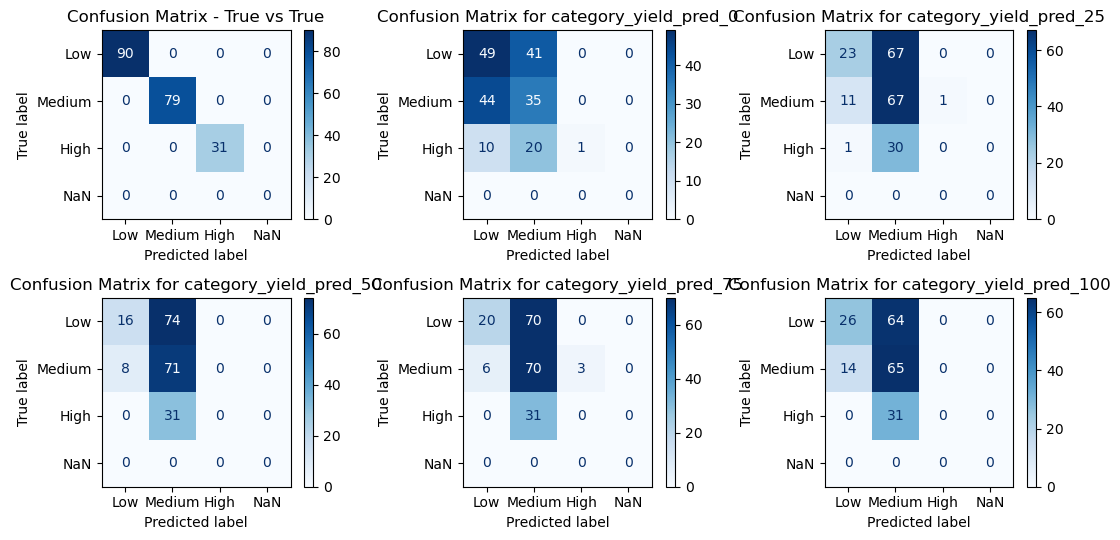

         Prediction Column  Macro F1-Score  \
0    category_yield_pred_0        0.242568   
1   category_yield_pred_25        0.229860   
2   category_yield_pred_50        0.209391   
3   category_yield_pred_75        0.226207   
4  category_yield_pred_100        0.235983   

                             F1-Score for each class  Weighted F1-Score  
0             [0.5077720207253886, 0.4, 0.0625, 0.0]           0.396185  
1               [0.368, 0.551440329218107, 0.0, 0.0]           0.383419  
2  [0.2807017543859649, 0.5568627450980392, 0.0, ...           0.346277  
3               [0.3448275862068966, 0.56, 0.0, 0.0]           0.376372  
4                [0.4, 0.5439330543933054, 0.0, 0.0]           0.394854  


In [673]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

true_labels = df_cat_lc['true_category']  

results_list = []
prediction_columns_cat = df_cat_lc.columns[1:]  

fig, axs = plt.subplots(2, 3, figsize=(11, 5.5))  
axs = axs.ravel() 

conf_matrix_true_vs_true = confusion_matrix(true_labels, true_labels, labels=[0, 1, 2, 3])
disp_true_vs_true = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_true_vs_true, display_labels=['Low', 'Medium', 'High', 'NaN'])

disp_true_vs_true.plot(cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title('Confusion Matrix - True vs True')

for i, col in enumerate(prediction_columns_cat[:5]):  
    predicted_labels = df_cat_lc[col].astype(int)  
    
    f1_macro = f1_score(true_labels, predicted_labels, average='macro', labels=[0, 1, 2, 3])
    f1_each_class = f1_score(true_labels, predicted_labels, average=None, labels=[0, 1, 2, 3])
    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted', labels=[0, 1, 2, 3])

    results_list.append({
        "Prediction Column": col,
        "Macro F1-Score": f1_macro,
        "F1-Score for each class": f1_each_class,
        "Weighted F1-Score": f1_weighted
    })

    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low', 'Medium', 'High', 'NaN'])

    disp.plot(cmap=plt.cm.Blues, ax=axs[i+1])  
    axs[i+1].set_title(f'Confusion Matrix for {col}')

plt.tight_layout()
plt.show()

results_f1_score_lc = pd.DataFrame(results_list)
print(results_f1_score_lc)


In [674]:
results_f1_score_lc

,Prediction Column,Macro F1-Score,F1-Score for each class,Weighted F1-Score
0,category_yield_pred_0,0.242568,"[0.5077720207253886, 0.4, 0.0625, 0.0]",0.396185
1,category_yield_pred_25,0.229860,"[0.368, 0.551440329218107, 0.0, 0.0]",0.383419
2,category_yield_pred_50,0.209391,"[0.2807017543859649, 0.5568627450980392, 0.0, ...",0.346277
3,category_yield_pred_75,0.226207,"[0.3448275862068966, 0.56, 0.0, 0.0]",0.376372
4,category_yield_pred_100,0.235983,"[0.4, 0.5439330543933054, 0.0, 0.0]",0.394854


# 3. LlamaIndex memory structure approach


In [362]:
import os

os.environ["OPENAI_API_KEY"] = ''


In [517]:
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.replicate import Replicate
from transformers import AutoTokenizer
from llama_index.core import Document

from llama_index.core import Settings


from langchain.chat_models import ChatAnyscale, ChatOpenAI
from llama_index.llms.langchain import LangChainLLM
from llama_index.core import PromptTemplate

from llama_index.llms.openai import OpenAI


In [528]:
api_key = ''

In [532]:
def extract_numeric_from_response(response_text):

    match = re.search(r'\d+(\.\d+)?', response_text)
    if match:
        return float(match.group())  
    else:
        print("No numeric value found in response.")
        return None

In [578]:
def run_pipeline_llamaindex(api_key, test_set, percentages, few_shot_examples):
    openai_llm = OpenAI(model="gpt-4o-mini", api_key=api_key, temperature=0.7)
    
    
    for focus_percentage in percentages:

        few_shot_docs = [Document(text=f"Question: {row['Prompts']}\nAnswer: {row['answer']}") 
                     for idx, row in few_shot_examples.iterrows()]
        index = VectorStoreIndex.from_documents(few_shot_docs, llm=openai_llm)

        query_engine = index.as_query_engine()

        column_name = f"yield_pred_{focus_percentage}"
        test_set[column_name] = pd.Series(dtype='float')

        retrieved_examples = "\n\n".join([f"Question: {row['Prompts']}\nAnswer: {row['answer']}" 
                                          for idx, row in few_shot_examples.iterrows()])
        
        combined_prompt = (
            f"You are an expert in organic chemistry reactions and causal reasoning. "
            f"Here are a few examples of question-answer pairs to learn from:\n\n{retrieved_examples}\n\n"
            
        )

        response_intro = openai_llm.predict(PromptTemplate(template=combined_prompt))
        print(f"Introductory Response: {combined_prompt}",
            f"Introductory Response: {response_intro}")

        index.insert(Document(text=f"Introductory Response: {response_intro}"))

        if focus_percentage == 0:
            print("No causal question asked")
        else:
            instruction = "Now I will be asking you some counterfactual questions. Please consider the following:"
            
            counterfactual_prompt = instruction + "\n" + "\n".join(counterfactual_questions)
            
            response_counterfactual = openai_llm.predict(PromptTemplate(template=counterfactual_prompt))
            print(f"Counterfactual Reasoning Response: {response_counterfactual}")

            index.insert(Document(text=f"Counterfactual Response: {response_counterfactual}"))

        for idx, row in test_set.iterrows():
            test_question = (
                f"What would the yield of the following reaction be? "
                f"Please answer with only the yield % number and nothing else: {row['Prompts']}"
            )

            retrieved_examples_and_responses = query_engine.query(
                "Retrieve few-shot examples and previously generated responses."
            )
            full_prompt = (
                f"{test_question}\n\nRefer to these examples and responses:\n"
                f"{retrieved_examples_and_responses.response}"
            )

            max_attempt = 5

            attempt = 0

            while attempt < 5:

                response_test = openai_llm.predict(PromptTemplate(template=full_prompt))

                numeric_response = extract_numeric_from_response(response_test)

                if numeric_response is not None:
                     test_set.at[idx, column_name] = numeric_response

                     break

                if attempt == 4:

                    test_set.at[idx, column_name] = numeric_response
                    break

                attempt += 1

            print(f"Index: {idx}, Question: {test_question}, Response: {numeric_response}")

            index.insert(Document(text=f"Test Response: {response_test}"))

    return test_set

In [573]:
df_test = df_test[['Prompts', 'answer']]

In [574]:
df_test.head(1)

,Prompts,answer
506,What would be the yield of the reaction involv...,66.22


In [579]:
df_runs = []

n_runs = 5

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}")
    df_results_llamaindex = run_pipeline_llamaindex(api_key, df_test.head(1), percentages, df_few_shot_6)
    df_runs.append(df_results_llamaindex)

df_combined = pd.concat(df_runs, axis=0, keys=range(n_runs))



Run 1/5


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/4035149076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[column_name] = pd.Series(dtype='float')


Introductory Response: You are an expert in organic chemistry reactions and causal reasoning. Here are a few examples of question-answer pairs to learn from:

Question: What would be the yield of the reaction involving Reactant smiles 1: COC(=O)CN1CCNCC1
Reactant smiles 2: C1=CC(=CC=C1Br)Br
Solvent smiles: C1COCCO1
The Base smiles: C(=O)([O-])[O-].[Cs+].[Cs+]
The Metal catalyst smiles: None
The ligand smiles: ligand_1    C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
ligand_2                                                 None
Name: 474, dtype: object
To give the following product smiles: COC(=O)CN1CCN(CC1)C2=CC=C(C=C2)Br
Knowing that: 
The Temperature of the reaction: 85.0
Metal catalyst amount is: 1e-05
Amine (reactant 1) amount: 0.00063
Halide (reactant 2) amount: 0.00158
Base amount: 0.00095
Ligand amount: 4e-05
Reaction volume: 0.0015
Solvent 1: 2.25
Solvent 2: 0.73
Amine (reactant 1) molecular weight: 158.2
Amine (reactant 1) molecular volume: 198.02723
Amine (reactant 1) sur

In [580]:
df_combined_filtered = df_combined.applymap(extract_numeric)

df_average_llamaindex = df_combined_filtered.groupby(level=1).mean()



/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_26620/2656083537.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_combined_filtered = df_combined.applymap(extract_numeric)


In [581]:

df_cat_li = pd.DataFrame()

df_cat_li['true_category'] = df_average_llamaindex['answer'].apply(categorize_yield)

prediction_columns = ['yield_pred_0', 'yield_pred_25', 'yield_pred_50', 'yield_pred_75', 'yield_pred_100']

for col in prediction_columns:
    
    df_cat_li[f"category_{col}"] = df_average_llamaindex[col].apply(categorize_yield)

df_cat_li


,true_category,category_yield_pred_0,category_yield_pred_25,category_yield_pred_50,category_yield_pred_75,category_yield_pred_100
506,1,NaN,NaN,NaN,0,NaN


In [582]:
print((df_cat_li == "NaN").sum())

true_category              0
category_yield_pred_0      1
category_yield_pred_25     1
category_yield_pred_50     1
category_yield_pred_75     0
category_yield_pred_100    1
dtype: int64


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

x_limits = [-0.1, 2.1]  
y_limits = [0, 150] 
x_ticks = [0, 1, 2]

axs[0][0].hist(df_cat_li[df_cat_li.columns[0]], bins=20, color='#FFE6F2', alpha=0.7)
axs[0][0].set_title('Yield Distribution - True')
axs[0][0].set_xlabel('Yield')
axs[0][0].set_ylabel('Categories')
axs[0][0].set_xlim(x_limits)
axs[0][0].set_ylim(y_limits)
axs[0][0].set_xticks(x_ticks)


axs[0][1].hist(df_cat_li[df_cat_li.columns[1]], bins=20, color='#FFB3D1', alpha=0.7)
axs[0][1].set_title('Yield Distribution - 0% Causality')
axs[0][1].set_xlabel('Yield')
axs[0][1].set_ylabel('Categories')
axs[0][1].set_xlim(x_limits)
axs[0][1].set_ylim(y_limits)
axs[0][1].set_xticks(x_ticks)

axs[0][2].hist(df_cat_li[df_cat_li.columns[2]], bins=20, color='#FF99BD', alpha=0.7)
axs[0][2].set_title('Yield Distribution - 25% Causality')
axs[0][2].set_xlabel('Yield')
axs[0][2].set_ylabel('Categories')
axs[0][2].set_xlim(x_limits)
axs[0][2].set_ylim(y_limits)
axs[0][2].set_xticks(x_ticks)

axs[1][0].hist(df_cat_li[df_cat_li.columns[3]], bins=20, color='#FF80AA', alpha=0.7)
axs[1][0].set_title('Yield Distribution - 50% Causality')
axs[1][0].set_xlabel('Yield')
axs[1][0].set_ylabel('Categories')
axs[1][0].set_xlim(x_limits)
axs[1][0].set_ylim(y_limits)
axs[1][0].set_xticks(x_ticks)

axs[1][1].hist(df_cat_li[df_cat_li.columns[4]], bins=20, color='#FF6696', alpha=0.7)
axs[1][1].set_title('Yield Distribution - 75% Causality')
axs[1][1].set_xlabel('Yield')
axs[1][1].set_ylabel('Categories')
axs[1][1].set_xlim(x_limits)
axs[1][1].set_ylim(y_limits)
axs[1][1].set_xticks(x_ticks)

axs[1][2].hist(df_cat_li[df_cat_li.columns[5]], bins=20, color='#FF0047', alpha=0.7)
axs[1][2].set_title('Yield Distribution - 100% Causality')
axs[1][2].set_xlabel('Yield')
axs[1][2].set_ylabel('Categories')
axs[1][2].set_xlim(x_limits)
axs[1][2].set_ylim(y_limits)
axs[1][2].set_xticks(x_ticks)

plt.tight_layout()
plt.show()

In [ ]:

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd


true_labels = df_cat_li['true_category']  

results_list = []
prediction_columns_cat = df_cat_li.columns[1:]  

fig, axs = plt.subplots(2, 3, figsize=(11, 5.5))  
axs = axs.ravel() 

conf_matrix_true_vs_true = confusion_matrix(true_labels, true_labels, labels=[0, 1, 2, 3])
disp_true_vs_true = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_true_vs_true, display_labels=['Low', 'Medium', 'High', 'NaN'])

disp_true_vs_true.plot(cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title('Confusion Matrix - True vs True')

for i, col in enumerate(prediction_columns_cat[:5]): 
    predicted_labels = df_cat_li[col].astype(int) 
    
    f1_macro = f1_score(true_labels, predicted_labels, average='macro', labels=[0, 1, 2, 3])
    f1_each_class = f1_score(true_labels, predicted_labels, average=None, labels=[0, 1, 2, 3])
    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted', labels=[0, 1, 2, 3])

    results_list.append({
        "Prediction Column": col,
        "Macro F1-Score": f1_macro,
        "F1-Score for each class": f1_each_class,
        "Weighted F1-Score": f1_weighted
    })

    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low', 'Medium', 'High', 'NaN'])

    disp.plot(cmap=plt.cm.Blues, ax=axs[i+1]) 
    axs[i+1].set_title(f'Confusion Matrix for {col}')

plt.tight_layout()
plt.show()

results_f1_score_lc = pd.DataFrame(results_list)
print(results_f1_score_lc)

results_f1_score_lc